In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
import torch
from torchvision import transforms
dtype = torch.float

In [3]:
device = torch.device("cuda")

### Image

In [7]:
IM = Path('data/rando/will_ferrel.jpeg')

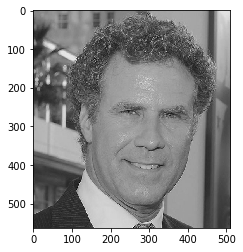

In [8]:
img = open_image(IM)
plt.imshow(img);

In [11]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()

In [16]:
m_vgg = to_gpu(vgg16(True)).eval()
# m_vgg = vgg16(True).eval()  # cpu
set_trainable(m_vgg, False)
# don't waste time/memory calculating gradients

### replace max -> average

In [7]:
def replace_pooling_layers(m):
    # replace MaxPool2d w/ AdaptiveAvgPool2d
    pool_layers = [i for i,o in enumerate(children(m)) if isinstance(o,nn.MaxPool2d)]
    conv_outs = [m[i-3].out_channels for i in pool_layers]

    for c,o in zip(pool_layers, conv_outs):
        m[c] = nn.AdaptiveAvgPool2d(o)
    return m

In [8]:
replace_pooling_layers(m_vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): AdaptiveAvgPool2d(output_size=64)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): AdaptiveAvgPool2d(output_size=128)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): 

In [9]:
# find all the layers before maxpool layers -> typically the best representation available at that grid size
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.AdaptiveAvgPool2d)]
block_ends

[5, 12, 22, 32, 42]

### features

In [17]:
# find all the layers before maxpool layers -> typically the best representation available at that grid size
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [16]:
# find conv layers after pool layers -> used in the paper
block_ends = [i+1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends.pop()
block_ends

[7, 14, 24, 34]

In [18]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])   # getting 32nd layer as module
# every forward pass, the 32nd layer's output will be stored in sf.features

### Fastai transforms

In [12]:
_, val_tfms = tfms_from_model(vgg16, 288)

In [13]:
img_tfm = val_tfms(img)

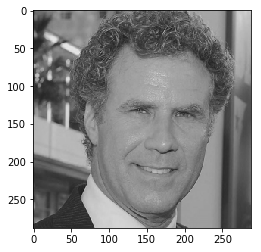

In [14]:
plt.imshow(val_tfms.denorm(np.rollaxis(img_tfm,0,3)))

### LBFGS (Jeremy's method)

In [19]:
m_vgg(V(img_tfm[None]))         # calls forward on the vgg network (we're throwing away the output)
targ_v = sf.features.clone()  # grabbing the features we stored w/ the forward hook
targ_v.shape

torch.Size([1, 512, 36, 36])

In [20]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)          # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v])

In [21]:
opt_img_v, optimizer = get_opt()

In [22]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.item()}')
    loss.backward()
    n_iter+=1
    return loss

In [23]:
def actn_loss2(x):
    m_vgg(x)              # calls forward on network and doesn't save results
    #out = V(sf.features)  # chosen layer activations => error: variable does not require grad and does not have a grad_fn
    #out = V(sf.features, requires_grad=True)  # this avoids error but results in no drop in loss...
    out = sf.features  # remove variable to avoid above error and still optimize
    return F.mse_loss(out, targ_v)*1000

In [24]:
max_iter = 1000
show_iter = 100
n_iter=0

while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 0, loss: 4.868215084075928


KeyboardInterrupt: 

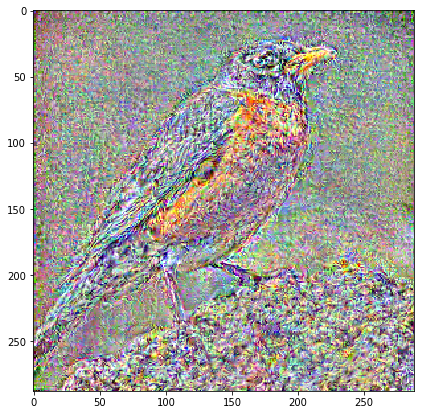

In [82]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### Conv3-1 & 

In [55]:
max_iter = 1000
show_iter = 100
n_iter=0

while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 0, loss: 134.95396423339844
Iteration: 100, loss: 3.801807403564453
Iteration: 200, loss: 2.4772610664367676
Iteration: 300, loss: 2.0076985359191895
Iteration: 400, loss: 1.7464966773986816
Iteration: 500, loss: 1.577243447303772
Iteration: 600, loss: 1.459909439086914
Iteration: 700, loss: 1.37100350856781
Iteration: 800, loss: 1.2998313903808594
Iteration: 900, loss: 1.242445945739746
Iteration: 1000, loss: 1.1965042352676392


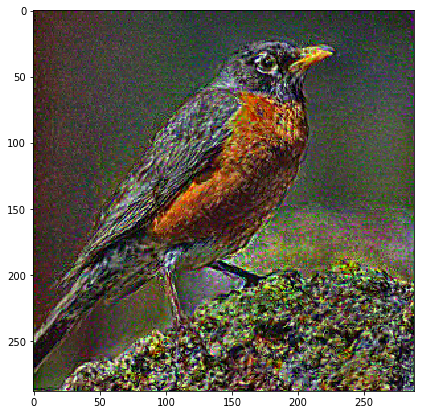

In [56]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

## Style Match

In [18]:
class image():
    shape = (291, 483, 3)
    def __init__(self): self

img = image()
img.shape

(291, 483, 3)

In [12]:
style_fn = PATH/'style'/'starry_night.jpg'
style_img = open_image(style_fn)
style_img.shape, img.shape

((480, 606, 3), (291, 483, 3))

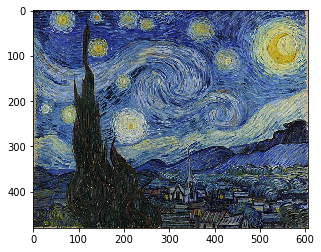

In [11]:
plt.imshow(style_img);

In [13]:
# resize style image to be same size as target image
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [14]:
style = scale_match(img, style_img)
style.shape

(291, 483, 3)

In [9]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img*1.2)[None], requires_grad=True)        # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v])

In [57]:
opt_img_v, optimizer = get_opt()

In [17]:
# save features for all block_ends -> array of activation layers
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [18]:
style_tfm = val_tfms(style)

In [19]:
m_vgg(V(style_tfm[None]))
targ_styles = [sf.features.clone() for sf in sfs]
[s.shape for s in targ_styles]

[torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [20]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1) # flatten batch (1) and channel, height X width
        return torch.mm(x, x.t())/input.numel()*1e6
    
        #np.square(input.numel())*4  -> normalizer to mse used in the paper...
        
        # matrix multiply w/ transpose
        # normalize by dividing by number of elements (b*c*h*w)
        # results in a tiny number so we multiply by a big number (1e6) to make it more sensible

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

## Style Transfer

In [25]:
opt_img_v, optimizer = get_opt()

In [26]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

NameError: name 'sfs' is not defined

### Try w/ duplicated input image instead of noise

In [23]:
opt_img_v = V(img_tfm.copy()[None], requires_grad=True)
optimizer = optim.LBFGS([opt_img_v])

In [24]:
def comb_loss(x):
    # 1e5 => 168.55975341796875
    # 1e6 => 648.6123657226562
    # 1e7 => 2057.2021484375
    m_vgg(opt_img_v)
    outs = [sf.features for sf in sfs]
    style_losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]   # content loss
    content_loss = F.mse_loss(outs[3], targ_vs[3])                           # style losses
    style_loss = sum(style_losses)
#     print(f'content loss: {content_loss}')
#     print(f'style_loss: {style_loss}')
    return (content_loss*1e6) + style_loss                                   # losses added together w/ multiplier

In [189]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 0, loss: 380263.28125
Iteration: 100, loss: 89.0960693359375
Iteration: 200, loss: 56.79451370239258
Iteration: 300, loss: 47.691768646240234
Iteration: 400, loss: 43.21055603027344
Iteration: 500, loss: 40.54647445678711
Iteration: 600, loss: 38.77214050292969
Iteration: 700, loss: 37.56357955932617
Iteration: 800, loss: 36.653324127197266
Iteration: 900, loss: 35.93981170654297
Iteration: 1000, loss: 35.35456085205078


#### 1e5

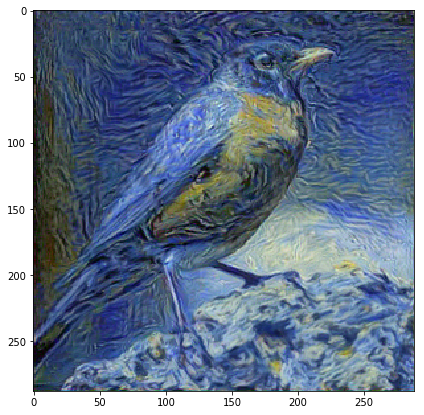

In [181]:
#=> 135.58486938476562
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### 1e6

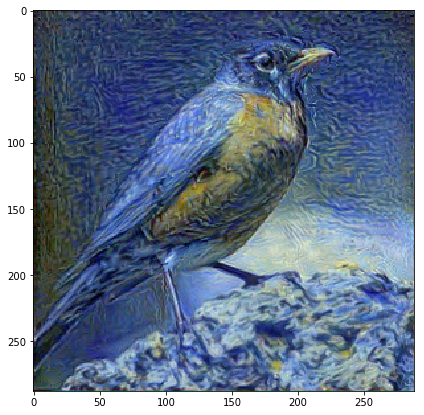

In [186]:
#=> 442.21685791015625
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### Conv3-1

In [26]:
max_iter = 1000
show_iter = 100

n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 0, loss: 2252082.5
Iteration: 100, loss: 2183.73681640625
Iteration: 200, loss: 526.4005126953125
Iteration: 300, loss: 363.7401428222656
Iteration: 400, loss: 314.3968200683594
Iteration: 500, loss: 293.0018310546875
Iteration: 600, loss: 280.61572265625
Iteration: 700, loss: 272.6527404785156
Iteration: 800, loss: 267.1320495605469
Iteration: 900, loss: 263.0524597167969
Iteration: 1000, loss: 259.88140869140625


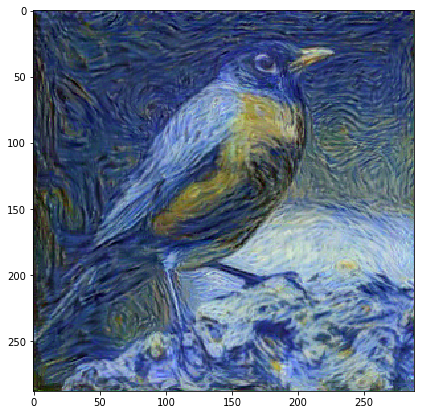

In [27]:
#=> 11.658407211303711
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);